# Sequential model

## load the library

In [21]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras import utils as np_utils
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

## Data preperation

In [22]:
## report read
reports = pd.read_excel('Reports_data.xlsx') 
#'report_body' has be list as field which will store the radiology reports
reports = reports.fillna('N/A')
reports = reports[reports['Annotation'].isin(['Non-Acute', 'Acute'])]

##############
possible_labels = reports.Annotation.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)

{'Non-Acute': 0, 'Acute': 1}


In [23]:
train_size = int(len(reports) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(reports) - train_size))

Train size: 96263
Test size: 41256


In [24]:
reports

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,modality,impression,Annotation,impression_cleaned
0,0,0,0,DX,1 ct evident acute abdominopelvic abnormality ...,Non-Acute,1 ct evident acute abdominopelvic abnormality ...
1,1,1,1,MR,acute fracture dislocation right humerus right...,Non-Acute,acute fracture dislocation right humerus right...
2,2,2,2,DX,moderate tricompartmental arthrosis,Non-Acute,moderate tricompartmental arthrosis
3,3,3,3,DX,pulmonary edema type pattern appropriate clini...,Non-Acute,pulmonary edema type pattern appropriate clini...
4,4,4,4,DX,acute fracture borderline widening scapholunat...,Non-Acute,acute fracture borderline widening scapholunat...
...,...,...,...,...,...,...,...
137514,138441,138441,138441,N/A,negative study acute dvt right lower extremity,Non-Acute,negative study acute dvt right lower extremity
137515,138442,138442,138442,N/A,acute traumatic findings chest,Non-Acute,acute traumatic findings chest
137516,138443,138443,138443,N/A,acute fracture traumatic malalignment,Non-Acute,acute fracture traumatic malalignment
137517,138444,138444,138444,N/A,acute fracture malalignment cervical spine mul...,Non-Acute,acute fracture malalignment cervical spine mul...


In [25]:
train_report = reports['impression_cleaned'][:train_size]
train_annotation = reports['Annotation'][:train_size]

test_report = reports['impression_cleaned'][train_size:]
test_annotation = reports['Annotation'][train_size:]

## Model training

In [26]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [27]:
tokenize.fit_on_texts(train_report) # only fit on train
x_train = tokenize.texts_to_matrix(train_report)
x_test = tokenize.texts_to_matrix(test_report)

In [28]:
encoder = LabelEncoder()
encoder.fit(train_annotation)
y_train = encoder.transform(train_annotation)
y_test = encoder.transform(test_annotation)

In [29]:
num_classes = np.max(y_train) + 1
y_train = to_categorical(y_train, num_classes)
y_test =  to_categorical(y_test, num_classes)

In [30]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (96263, 1000)
x_test shape: (41256, 1000)
y_train shape: (96263, 2)
y_test shape: (41256, 2)


In [31]:
batch_size = 32
epochs = 2

In [32]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 86636 samples, validate on 9627 samples
Epoch 1/2
86112/86636 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9534

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


86636/86636 [==============================] - 3s 40us/sample - loss: 0.1198 - accuracy: 0.9534 - val_loss: 0.0973 - val_accuracy: 0.9586
Epoch 2/2
86636/86636 [==============================] - 3s 38us/sample - loss: 0.0901 - accuracy: 0.9640 - val_loss: 0.0975 - val_accuracy: 0.9606


In [34]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

Test accuracy: 0.9596665


In [35]:
y_prob = model.predict(x_test)
y_pred =np.argmax(y_prob,axis=1)

In [36]:
y_test[:,1]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [37]:
y_pred

array([0, 1, 1, ..., 1, 1, 1])

## Performance evaluation

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test[:,1], y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68      2899
         1.0       0.97      0.99      0.98     38357

    accuracy                           0.96     41256
   macro avg       0.87      0.80      0.83     41256
weighted avg       0.96      0.96      0.96     41256



In [39]:
import numpy as np
np.__version__

'1.19.5'

## Explaination

In [40]:
import shap

attrib_data = x_train[:10000]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 100
shap_vals = explainer.shap_values(x_test[:num_explanations])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


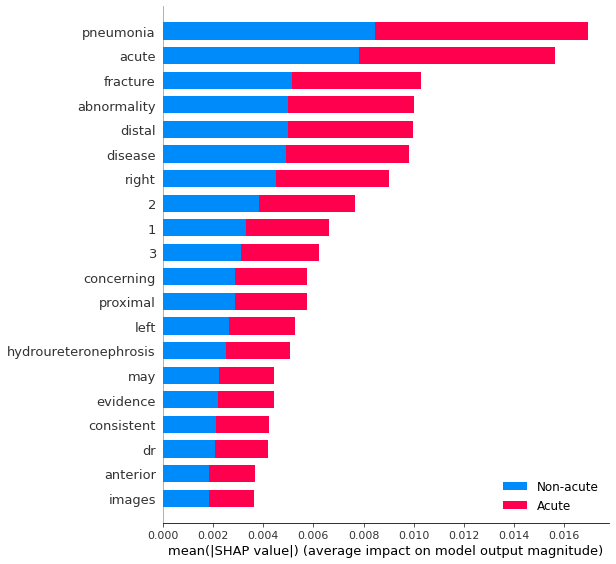

In [41]:
words = dict(tokenize.word_index.items())
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=['Acute', 'Non-acute'])